Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# An example of lazy resampling functionals

This is a simple example of preprocessing using the lazy resampling mechanism.
It focuses on the basic implementation at the 'functional' level, showing a set of transforms applied sequentially.

It doesn't cover topics of using these transforms along with other important preprocessing concepts such as `Compose`, `DataLoader`, `CacheDataset`.

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!pip install memory_profiler

## Setup imports

In [ ]:
import monai
from monai.visualize import matshow3d
import monai.transforms as mt
from monai.config import print_config

%load_ext memory_profiler
print_config()

## Preparing the data and utilities

This section downloads a testing volume and prepare a utility function for inspecting the results

In [ ]:
def plot_img_operations(img):

    if isinstance(img, list):
        print(f"patch metadata of patch idx 0 out of {len(img)} samples.\n")
        img_0 = img[0]
    else:
        img_0 = img
    print(f"img {img_0.shape} -- applied_operations:")
    if not img_0.applied_operations:
        print("(empty stack)")
    for ops in img_0.applied_operations:
        print(ops["class"])
    print("\n")

    print("img -- pending_operations:")
    if not img_0.pending_operations:
        print("(empty stack)")
    for ops in img_0.pending_operations:
        print(ops["class"])

    matshow3d(img, show=True, every_n=5)


monai.apps.download_url(
    "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/avg152T1_RL_nifti.nii.gz"
)
filename = "./avg152T1_RL_nifti.nii.gz"

## Load and visualize the volume

img torch.Size([1, 361, 433, 361]) -- applied_operations:
Orientation
SpatialResample


img -- pending_operations:
(empty stack)


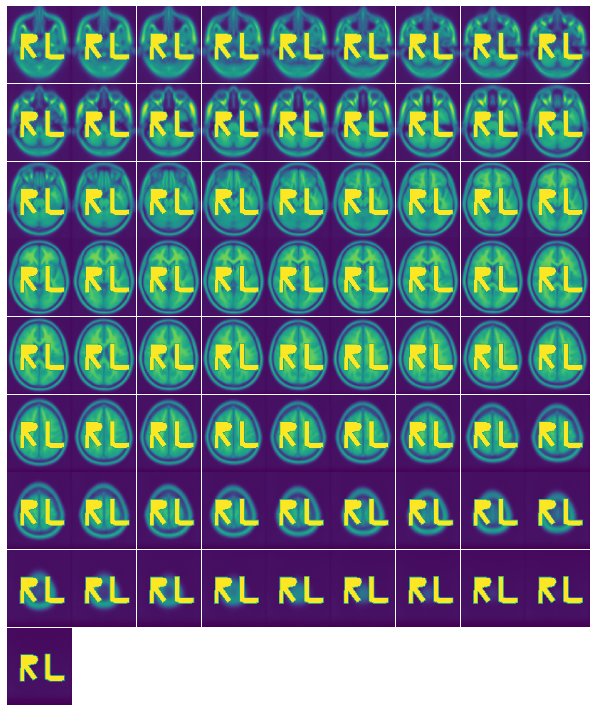

In [4]:
filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)

img = orientation(img)
img = spacing(img)

plot_img_operations(img)

## The preprocessing pipeline

This section applies some preprocessing steps:
- change the volume orientation (`monai.transforms.Orientation`)
- Resize to the desired resolution (`monai.transforms.Spacing`)
- Randomly sample multiple image patches from the volume (`monai.transforms.RandSpatialCropSamples`)
- Randomly rotate each image patch (`monai.transforms.RandRotate`)
- Randomly zoom each image patch (`monai.transforms.RandZoom`)

The transforms are applied sequentially and independently.
After these operations, it generates 4 images patches, each patch is
a MetaTensor, with `img.applied_operations` tracking the parameters of the transforms.

patch metadata of patch idx 0 out of 4 samples.

img torch.Size([1, 261, 168, 161]) -- applied_operations:
Orientation
SpatialResample
RandSpatialCropSamples
RandRotate
RandZoom


img -- pending_operations:
(empty stack)


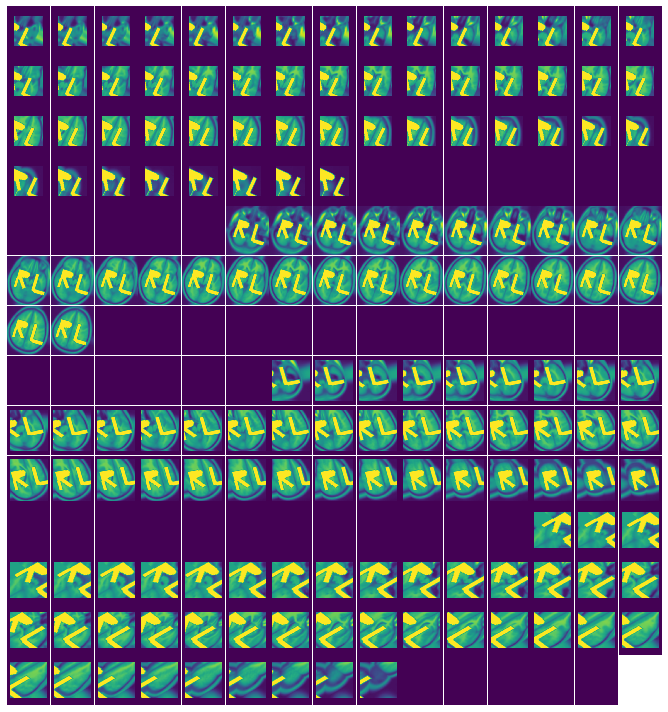

In [5]:
filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

# create instances of the transforms
orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)
rand_windows = mt.RandSpatialCropSamples(roi_size=(180, 180, 100), num_samples=4, random_size=True)
rotate = mt.RandRotate(range_x=1, range_y=1, prob=1.0)
zoom = mt.RandZoom(prob=1.0, min_zoom=0.6, max_zoom=0.8, keep_size=False)

rand_windows.set_random_state(0)
rotate.set_random_state(0)
zoom.set_random_state(0)

# apply the preprocessing (Compose)
img = orientation(img)
img = spacing(img)
img = rand_windows(img)
reg_imgs = []
for i in img:
    i = rotate(i)
    i = zoom(i)
    reg_imgs.append(i)

plot_img_operations(reg_imgs)
del img

## The preprocessing pipeline evaluated lazily

Instead of evaluate the transforms directly with a potentially expensive image resampling step,
lazy resampling functional can push the transform parameters to the MetaTensor `pending_operations` stack.

The `pending_operations` can later be evaluated with `monai.transforms.lazy.functional.apply_transforms`
in a single resampling step. This is faster, more accurate, and requiring less memory than the regular preprocessing pipeline.

Note that before running the transforms, the flags `lazy_evaluation` are set to `True`.

patch metadata of patch idx 0 out of 4 samples.

img torch.Size([1, 91, 109, 91]) -- applied_operations:
(empty stack)


img -- pending_operations:
Orientation
SpatialResample
RandSpatialCropSamples
RandRotate
RandZoom


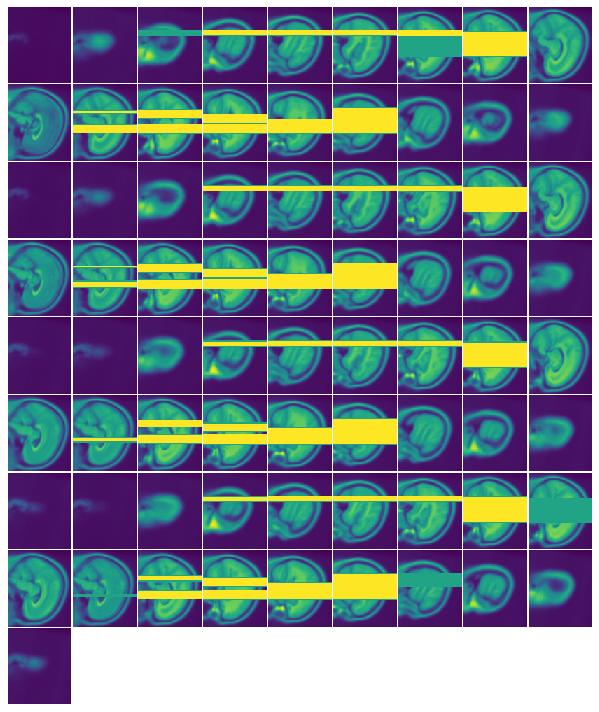

In [6]:
filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)
rand_windows = mt.RandSpatialCropSamples(roi_size=(180, 180, 100), num_samples=4, random_size=True)
rotate = mt.RandRotate(range_x=1, range_y=1, prob=1.0)
zoom = mt.RandZoom(prob=1.0, min_zoom=0.6, max_zoom=0.8, keep_size=False)

rand_windows.set_random_state(0)
rotate.set_random_state(0)
zoom.set_random_state(0)

spacing.lazy_evaluation = True
orientation.lazy_evaluation = True
rand_windows.lazy_evaluation = True
rotate.lazy_evaluation = True
zoom.lazy_evaluation = True

# apply the preprocessing (Compose)
img = orientation(img)
img = spacing(img)
img = rand_windows(img)
imgs = []
for i in img:
    i = rotate(i)
    i = zoom(i)
    imgs.append(i)

plot_img_operations(imgs)

After applying the transforms, the primary image data are unchanged, but the MetaTensors' `pending_operations` have the expected items created by the transform functionals to track the transforms to be applied.

The following step applies the pending operations as a single step of image resampling.

patch metadata of patch idx 0 out of 4 samples.

img torch.Size([1, 261, 168, 161]) -- applied_operations:
Orientation
SpatialResample
RandSpatialCropSamples
RandRotate
RandZoom


img -- pending_operations:
(empty stack)


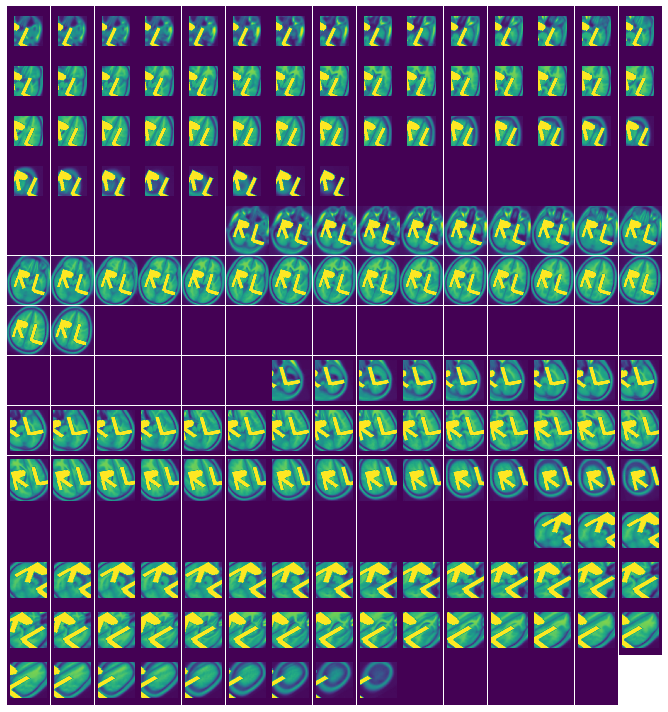

In [7]:
outputs = []
for i in imgs:
    img_t = mt.lazy.functional.apply_transforms(i, mode="bilinear", dtype=float, align_corners=True)[0]
    outputs.append(img_t)
plot_img_operations(outputs)
del imgs

## Voxel-wise differences between the regular approach and lazy resampling

patch metadata of patch idx 0 out of 4 samples.

img torch.Size([1, 261, 168, 161]) -- applied_operations:
Orientation
SpatialResample
RandSpatialCropSamples
RandRotate
RandZoom


img -- pending_operations:
(empty stack)


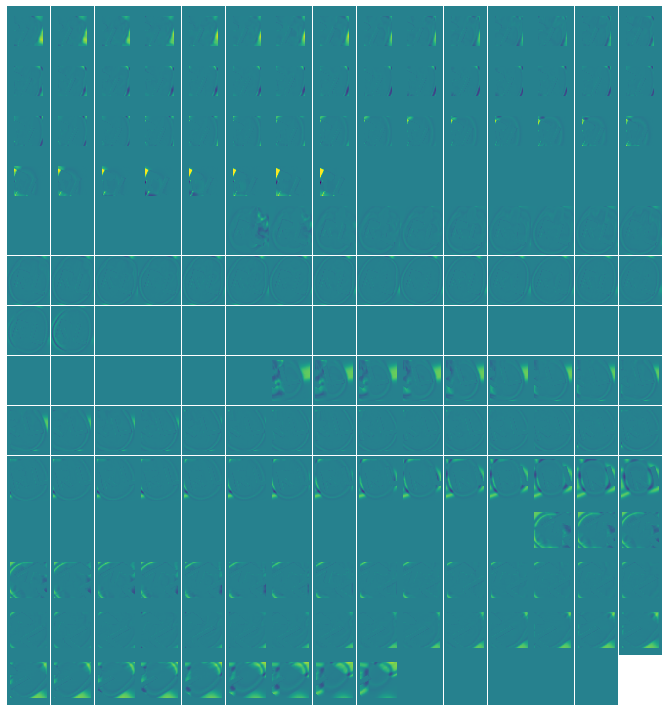

In [8]:
diffs = [nl - l for nl, l in zip(reg_imgs, outputs)]
plot_img_operations(diffs)

del reg_imgs, outputs

It is expected that by fusing the spatial transforms, the operation introduces less interpolation errors.

## Compare the computational time

### The regular non-lazy evaluation

In [9]:
%%timeit

filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)

rand_windows = mt.RandSpatialCropSamples(roi_size=(180, 180, 100), num_samples=4, random_size=True)
rotate = mt.RandRotate(range_x=1, range_y=1, prob=1.0)
zoom = mt.RandZoom(prob=1.0, min_zoom=0.6, max_zoom=0.8, keep_size=False)

rand_windows.set_random_state(0)
rotate.set_random_state(0)
zoom.set_random_state(0)

img = orientation(img)
img = spacing(img)
img = rand_windows(img)
imgs = []
for i in img:
    i = rotate(i)
    i = zoom(i)
    imgs.append(i)
del img, imgs

9.42 s ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Lazy resampling

In [10]:
%%timeit

filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)

rand_windows = mt.RandSpatialCropSamples(roi_size=(180, 180, 100), num_samples=4, random_size=True)
rotate = mt.RandRotate(range_x=1, range_y=1, prob=1.0)
zoom = mt.RandZoom(prob=1.0, min_zoom=0.6, max_zoom=0.8, keep_size=False)

rand_windows.set_random_state(0)
rotate.set_random_state(0)
zoom.set_random_state(0)

spacing.lazy_evaluation = True
orientation.lazy_evaluation = True
rand_windows.lazy_evaluation = True
rotate.lazy_evaluation = True
zoom.lazy_evaluation = True

img = orientation(img)
img = spacing(img)
img = rand_windows(img)
imgs = []
for i in img:
    i = rotate(i)
    i = zoom(i)
    imgs.append(i)

outputs = []
for i in imgs:
    img_t = mt.lazy.functional.apply_transforms(i, mode="bilinear", dtype=float, align_corners=True)[0]
    outputs.append(img_t)
del img, imgs, outputs

1.96 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Compare the memory footprint

### The regular non-lazy evaluation

In [11]:
%%memit

filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)

rand_windows = mt.RandSpatialCropSamples(roi_size=(180, 180, 100), num_samples=4, random_size=True)
rotate = mt.RandRotate(range_x=1, range_y=1, prob=1.0)
zoom = mt.RandZoom(prob=1.0, min_zoom=0.6, max_zoom=0.8, keep_size=False)

rand_windows.set_random_state(0)
rotate.set_random_state(0)
zoom.set_random_state(0)

img = orientation(img)
img = spacing(img)
img = rand_windows(img)
imgs = []
for i in img:
    i = rotate(i)
    i = zoom(i)
    imgs.append(i)
del imgs, img

peak memory: 6418.12 MiB, increment: 2995.80 MiB


### Lazy resampling

In [12]:
%%memit

filename = "./avg152T1_RL_nifti.nii.gz"
img = mt.LoadImage(image_only=True, ensure_channel_first=True)(filename)

orientation = mt.Orientation("SPL")  # Superior, Posterior, Left
spacing = mt.Spacing(pixdim=0.5)

rand_windows = mt.RandSpatialCropSamples(roi_size=(180, 180, 100), num_samples=4, random_size=True)
rotate = mt.RandRotate(range_x=1, range_y=1, prob=1.0)
zoom = mt.RandZoom(prob=1.0, min_zoom=0.6, max_zoom=0.8, keep_size=False)

rand_windows.set_random_state(0)
rotate.set_random_state(0)
zoom.set_random_state(0)

spacing.lazy_evaluation = True
orientation.lazy_evaluation = True
rand_windows.lazy_evaluation = True
rotate.lazy_evaluation = True
zoom.lazy_evaluation = True

img = orientation(img)
img = spacing(img)
img = rand_windows(img)
imgs = []
for i in img:
    i = rotate(i)
    i = zoom(i)
    imgs.append(i)

outputs = []
for i in imgs:
    img_t = mt.lazy.functional.apply_transforms(i, mode="bilinear", dtype=float, align_corners=True)[0]
    outputs.append(img_t)

peak memory: 3422.36 MiB, increment: 0.01 MiB
